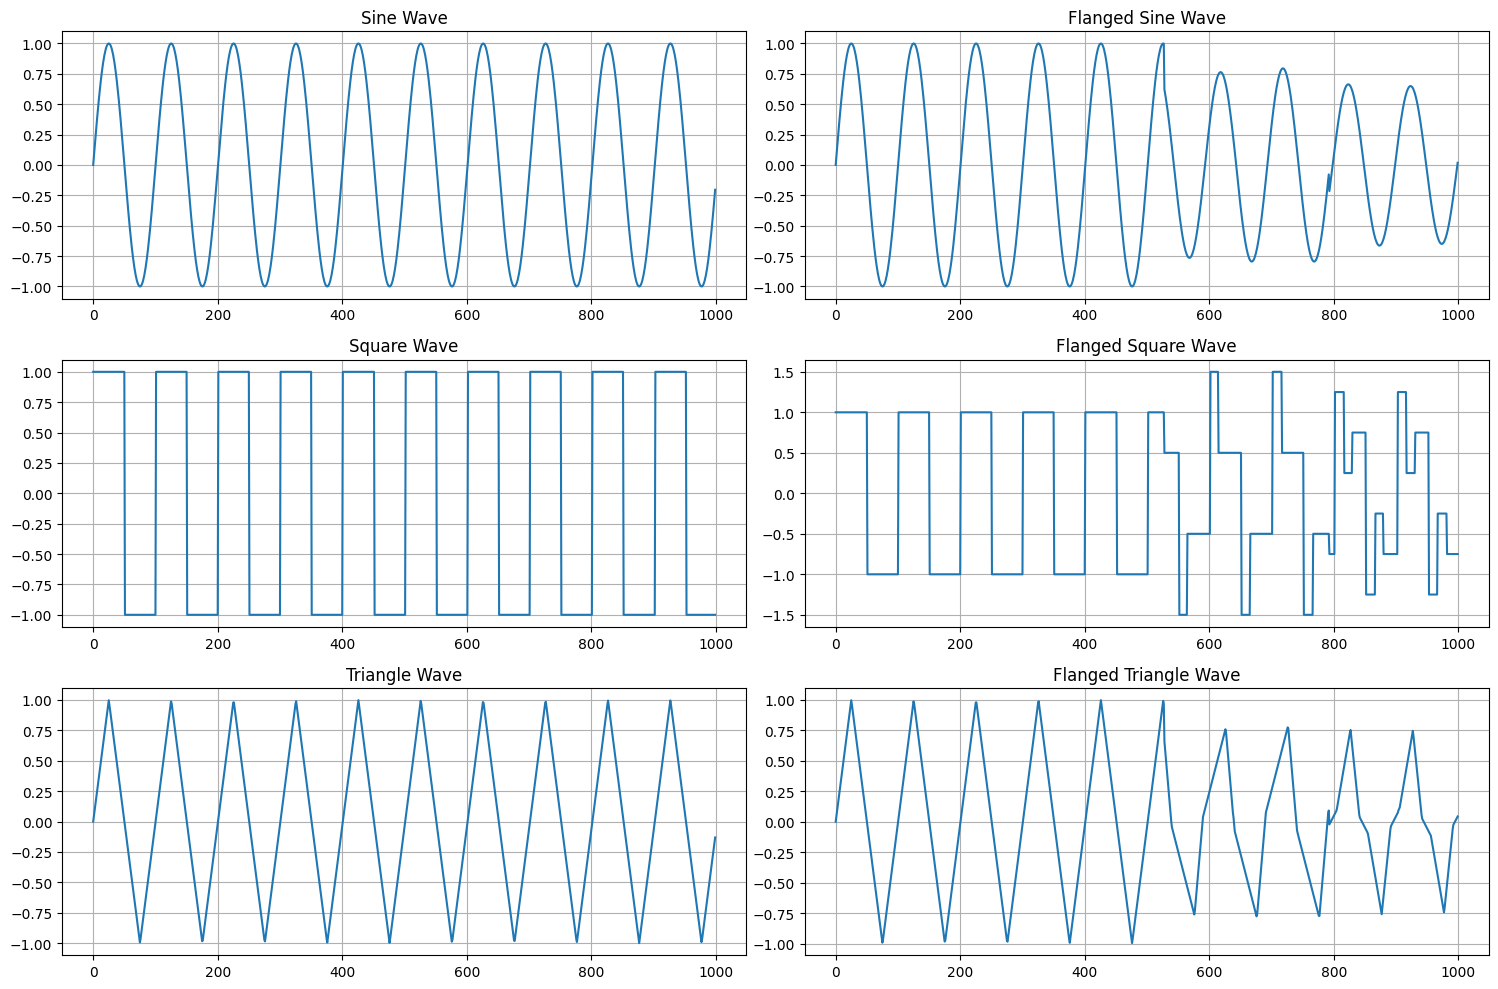

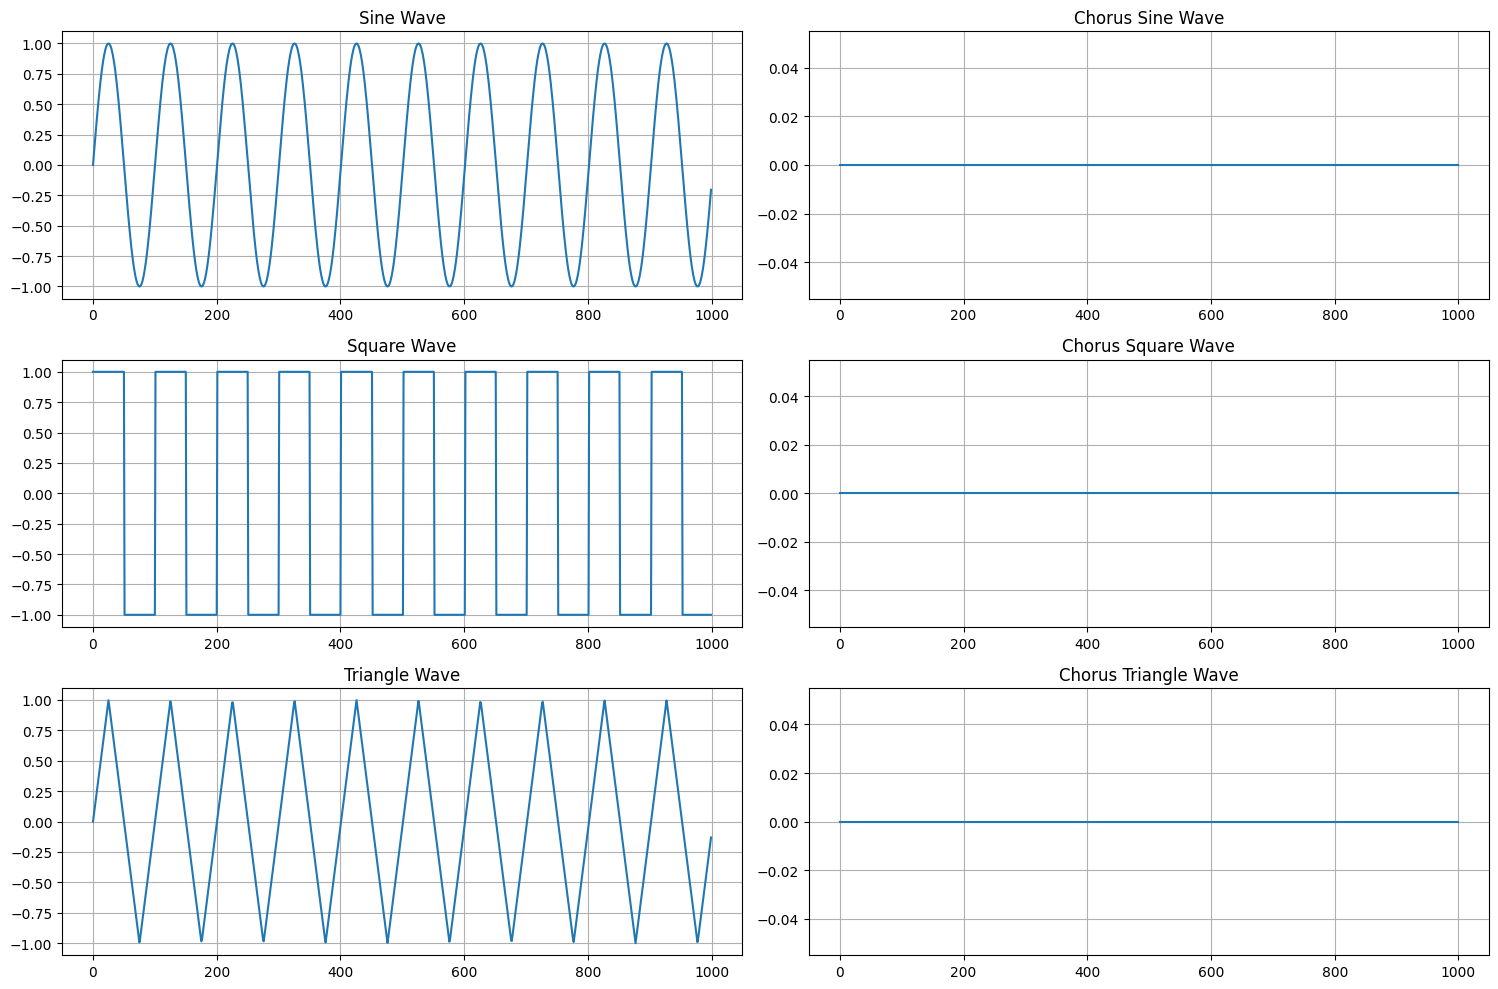

Playing original sine wave...
Playing flanged sine wave...
Playing chorus sine wave...
Playing original square wave...
Playing flanged square wave...
Playing chorus square wave...
Playing original triangle wave...
Playing flanged triangle wave...
Playing chorus triangle wave...


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import math
from abc import ABC, abstractmethod

class Oscillator(ABC):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1), detune=0):
        self._freq = freq
        self._amp = amp
        self._phase = phase
        self._sample_rate = sample_rate
        self._wave_range = wave_range
        self._detune = detune

        self._f = freq + detune
        self._a = amp
        self._p = phase

    @property
    def init_freq(self):
        return self._freq

    @property
    def init_amp(self):
        return self._amp

    @property
    def init_phase(self):
        return self._phase

    @property
    def freq(self):
        return self._f

    @freq.setter
    def freq(self, value):
        self._f = value + self._detune
        self._post_freq_set()

    @property
    def amp(self):
        return self._a

    @amp.setter
    def amp(self, value):
        self._a = value
        self._post_amp_set()

    @property
    def phase(self):
        return self._p

    @phase.setter
    def phase(self, value):
        self._p = value
        self._post_phase_set()

    def _post_freq_set(self):
        pass

    def _post_amp_set(self):
        pass

    def _post_phase_set(self):
        pass

    @abstractmethod
    def _initialize_osc(self):
        pass

    @staticmethod
    def squish_val(val, min_val=0, max_val=1):
        return (((val + 1) / 2) * (max_val - min_val)) + min_val

    @abstractmethod
    def __next__(self):
        return None

    def __iter__(self):
        self.freq = self._freq
        self.phase = self._phase
        self.amp = self._amp
        self._initialize_osc()
        return self

class SineOscillator(Oscillator):
    def _initialize_osc(self):
        self._i = 0
        self._step = (2 * math.pi * self._f) / self._sample_rate

    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = (self._i + self._step) % (2 * math.pi)
        return val * self._a

class SquareOscillator(Oscillator):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1), threshold=0, detune=0):
        super().__init__(freq, phase, amp, sample_rate, wave_range, detune)
        self.threshold = threshold

    def _initialize_osc(self):
        self._i = 0
        self._step = (2 * math.pi * self._f) / self._sample_rate

    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = (self._i + self._step) % (2 * math.pi)
        if val < self.threshold:
            val = self._wave_range[0]
        else:
            val = self._wave_range[1]
        return val * self._a

class SawtoothOscillator(Oscillator):
    def _post_freq_set(self):
        self._period = self._sample_rate / self._f
        self._post_phase_set()

    def _post_phase_set(self):
        self._p = ((self._p + 90) / 360) * self._period

    def _initialize_osc(self):
        self._i = 0

    def __next__(self):
        div = (self._i + self._p) / self._period
        val = 2 * (div - math.floor(0.5 + div))
        self._i = (self._i + 1) % self._period
        if self._wave_range != (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

class TriangleOscillator(SawtoothOscillator):
    def __next__(self):
        div = (self._i + self._p) / self._period
        val = 2 * (div - math.floor(0.5 + div))
        val = (abs(val) - 0.5) * 2
        self._i = (self._i + 1) % self._period
        if self._wave_range != (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

class DetunedOscillator:
    def __init__(self, base_osc_class, base_freq=440, detune_factors=None, amps=None, sample_rate=44100):
        if detune_factors is None:
            detune_factors = [-5, 0, 5]  # Default detune factors
        if amps is None:
            amps = [1, 1, 1]  # Default amplitudes for each detuned oscillator

        self.oscillators = [base_osc_class(freq=base_freq + detune, amp=amp, sample_rate=sample_rate) 
                            for detune, amp in zip(detune_factors, amps)]
        self.n = len(self.oscillators)

    def __iter__(self):
        for osc in self.oscillators:
            iter(osc)
        return self

    def __next__(self):
        return sum(next(osc) for osc in self.oscillators) / self.n

class NoiseOscillator:
    def __init__(self, amp=1, sample_rate=44100):
        self._a = amp
        self._sample_rate = sample_rate

    def __iter__(self):
        return self

    def __next__(self):
        return np.random.normal(0, 1) * self._a

class WaveAdder:
    def __init__(self, *oscillators):
        self.oscillators = oscillators
        self.n = len(oscillators)

    def __iter__(self):
        for osc in self.oscillators:
            iter(osc)
        return self

    def __next__(self):
        return sum(next(osc) for osc in self.oscillators) / self.n

class VCF:
    def __init__(self, cutoff_freq, sample_rate=44100, resonance=0.1):
        self.cutoff_freq = cutoff_freq
        self.sample_rate = sample_rate
        self.resonance = resonance
        self.alpha = self.calc_alpha()

    def calc_alpha(self):
        return math.exp(-2 * math.pi * self.cutoff_freq / self.sample_rate)

    def apply(self, signal):
        filtered_signal = []
        y = 0
        for x in signal:
            y = (1 - self.alpha) * x + self.alpha * y
            filtered_signal.append(y)
        return filtered_signal

class LFO(Oscillator):
    def __init__(self, freq=0.5, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1)):
        super().__init__(freq, phase, amp, sample_rate, wave_range)

    def _initialize_osc(self):
        self._i = 0
        self._step = (2 * math.pi * self._f) / self._sample_rate

    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = (self._i + self._step) % (2 * math.pi)
        return val * self._a

    def apply_vibrato(self, oscillator_samples, lfo_samples, base_freq=440, sample_rate=44100):
        vibrato_samples = []
        for i, sample in enumerate(oscillator_samples):
            vibrato_samples.append(sample * math.sin(2 * math.pi * (base_freq + lfo_samples[i]) * i / sample_rate))
        return vibrato_samples

    def apply_tremolo(self, oscillator_samples, lfo_samples):
        tremolo_samples = []
        for i, sample in enumerate(oscillator_samples):
            tremolo_samples.append(sample * (1 + lfo_samples[i]))
        return tremolo_samples

# Saturation
# Clipping سخت (Hard Clipping)
def hard_clipping(x, T):
    return np.clip(x, -T, T)

# Clipping نرم (Soft Clipping)
def soft_clipping(x, T):
    return T * np.tanh(x / T)

# اشباع متغیر (Variable Saturation)
def variable_saturation(x, T, a):
    return T * (np.abs(x / T) ** a) * np.sign(x)

# کمپرسور
class Compressor:
    def __init__(self, threshold, ratio, attack, release, sample_rate=44100):
        self.threshold = threshold
        self.ratio = ratio
        self.attack = attack
        self.release = release
        self.sample_rate = sample_rate
        self.gain = 1.0
        self.attack_coeff = np.exp(-1.0 / (self.attack * self.sample_rate))
        self.release_coeff = np.exp(-1.0 / (self.release * self.sample_rate))

    def process(self, signal):
        output = np.zeros_like(signal)
        for i in range(len(signal)):
            x = signal[i]
            if abs(x) > self.threshold:
                self.gain *= self.attack_coeff
                self.gain = max(self.gain, 1.0 / self.ratio)
            else:
                self.gain *= self.release_coeff
                self.gain = min(self.gain, 1.0)
            
            output[i] = x * self.gain
        return output

# Flanger effect
def flanger(signal, sample_rate, delay, depth, rate, feedback=0):
    N = len(signal)
    delay_samples = int(sample_rate * delay)
    depth_samples = int(sample_rate * depth)
    lfo = depth_samples * (1 + np.sin(2 * np.pi * rate * np.arange(N) / sample_rate)) / 2
    flanged_signal = np.zeros(N)
    feedback_buffer = np.zeros(N)

    for n in range(N):
        delay_n = int(lfo[n])
        if n - delay_samples - delay_n < 0:
            flanged_signal[n] = signal[n]
        else:
            flanged_signal[n] = signal[n] + feedback * feedback_buffer[n - delay_samples - delay_n]
            feedback_buffer[n] = flanged_signal[n]

    return flanged_signal

# Chorus effect
def chorus(signal, sample_rate, delay, depth, rate, num_voices=3, spread=0.002):
    N = len(signal)
    delay_samples = int(sample_rate * delay)
    depth_samples = int(sample_rate * depth)
    lfo = np.zeros((num_voices, N))

    for i in range(num_voices):
        lfo[i] = depth_samples * (1 + np.sin(2 * np.pi * (rate + i * spread) * np.arange(N) / sample_rate)) / 2

    chorus_signal = np.zeros(N)
    for i in range(N):
        for j in range(num_voices):
            delay_n = int(lfo[j, i])
            if i - delay_samples - delay_n >= 0:
                chorus_signal[i] += signal[i - delay_samples - delay_n]
        chorus_signal[i] /= num_voices

    return chorus_signal

# Define a function to generate samples from an oscillator
def generate_samples(oscillator, num_samples=1000):
    return np.array([next(oscillator) for _ in range(num_samples)])

# پارامترها
sample_rate = 44100
duration = 1  # مدت زمان سیگنال در ثانیه
num_samples = sample_rate * duration

# ایجاد نمونه موج سینوسی
sine_osc = SineOscillator(freq=440, amp=1, sample_rate=sample_rate)
sine_osc.__iter__()
sine_samples = generate_samples(sine_osc, num_samples)

# ایجاد نمونه موج مربعی
square_osc = SquareOscillator(freq=440, amp=1, sample_rate=sample_rate)
square_osc.__iter__()
square_samples = generate_samples(square_osc, num_samples)

# ایجاد نمونه موج مثلثی
triangle_osc = TriangleOscillator(freq=440, amp=1, sample_rate=sample_rate)
triangle_osc.__iter__()
triangle_samples = generate_samples(triangle_osc, num_samples)

# پارامترهای فلنجر
delay = 0.005  # Base delay time in seconds
depth = 0.002  # Depth of modulation in seconds
rate = 0.25  # Rate of LFO in Hz
feedback = 0.5  # Feedback amount

# اعمال افکت فلنجر
flanged_sine = flanger(sine_samples, sample_rate, delay, depth, rate, feedback)
flanged_square = flanger(square_samples, sample_rate, delay, depth, rate, feedback)
flanged_triangle = flanger(triangle_samples, sample_rate, delay, depth, rate, feedback)

# پارامترهای Chorus
chorus_delay = 0.03  # Base delay time in seconds
chorus_depth = 0.01  # Depth of modulation in seconds
chorus_rate = 1.5  # Rate of LFO in Hz
num_voices = 5  # Number of chorus voices
spread = 0.002  # Spread of LFO rates for voices

# اعمال افکت Chorus
chorus_sine = chorus(sine_samples, sample_rate, chorus_delay, chorus_depth, chorus_rate, num_voices, spread)
chorus_square = chorus(square_samples, sample_rate, chorus_delay, chorus_depth, chorus_rate, num_voices, spread)
chorus_triangle = chorus(triangle_samples, sample_rate, chorus_delay, chorus_depth, chorus_rate, num_voices, spread)

# نمایش سیگنال‌ها
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.title('Sine Wave')
plt.plot(sine_samples[:1000])
plt.grid()

plt.subplot(3, 2, 2)
plt.title('Flanged Sine Wave')
plt.plot(flanged_sine[:1000])
plt.grid()

plt.subplot(3, 2, 3)
plt.title('Square Wave')
plt.plot(square_samples[:1000])
plt.grid()

plt.subplot(3, 2, 4)
plt.title('Flanged Square Wave')
plt.plot(flanged_square[:1000])
plt.grid()

plt.subplot(3, 2, 5)
plt.title('Triangle Wave')
plt.plot(triangle_samples[:1000])
plt.grid()

plt.subplot(3, 2, 6)
plt.title('Flanged Triangle Wave')
plt.plot(flanged_triangle[:1000])
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.title('Sine Wave')
plt.plot(sine_samples[:1000])
plt.grid()

plt.subplot(3, 2, 2)
plt.title('Chorus Sine Wave')
plt.plot(chorus_sine[:1000])
plt.grid()

plt.subplot(3, 2, 3)
plt.title('Square Wave')
plt.plot(square_samples[:1000])
plt.grid()

plt.subplot(3, 2, 4)
plt.title('Chorus Square Wave')
plt.plot(chorus_square[:1000])
plt.grid()

plt.subplot(3, 2, 5)
plt.title('Triangle Wave')
plt.plot(triangle_samples[:1000])
plt.grid()

plt.subplot(3, 2, 6)
plt.title('Chorus Triangle Wave')
plt.plot(chorus_triangle[:1000])
plt.grid()

plt.tight_layout()
plt.show()

print("Playing original sine wave...")
sd.play(sine_samples, sample_rate)
sd.wait()

print("Playing flanged sine wave...")
sd.play(flanged_sine, sample_rate)
sd.wait()

print("Playing chorus sine wave...")
sd.play(chorus_sine, sample_rate)
sd.wait()

print("Playing original square wave...")
sd.play(square_samples, sample_rate)
sd.wait()

print("Playing flanged square wave...")
sd.play(flanged_square, sample_rate)
sd.wait()

print("Playing chorus square wave...")
sd.play(chorus_square, sample_rate)
sd.wait()

print("Playing original triangle wave...")
sd.play(triangle_samples, sample_rate)
sd.wait()

print("Playing flanged triangle wave...")
sd.play(flanged_triangle, sample_rate)
sd.wait()

print("Playing chorus triangle wave...")
sd.play(chorus_triangle, sample_rate)
sd.wait()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import math
from abc import ABC, abstractmethod

# تعریف کلاس‌های نوسان‌ساز
class Oscillator(ABC):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1), detune=0):
        self._freq = freq
        self._amp = amp
        self._phase = phase
        self._sample_rate = sample_rate
        self._wave_range = wave_range
        self._detune = detune

        self._f = freq + detune
        self._a = amp
        self._p = phase

    @abstractmethod
    def _initialize_osc(self):
        pass

    @staticmethod
    def squish_val(val, min_val=0, max_val=1):
        return (((val + 1) / 2) * (max_val - min_val)) + min_val

    @abstractmethod
    def __next__(self):
        return None

    def __iter__(self):
        self.freq = self._freq
        self.phase = self._phase
        self.amp = self._amp
        self._initialize_osc()
        return self

class SineOscillator(Oscillator):
    def _initialize_osc(self):
        self._i = 0
        self._step = (2 * math.pi * self._f) / self._sample_rate

    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = (self._i + self._step) % (2 * math.pi)
        return val * self._a

class SquareOscillator(Oscillator):
    def __init__(self, freq=440, phase=0, amp=1, sample_rate=44100, wave_range=(-1, 1), threshold=0, detune=0):
        super().__init__(freq, phase, amp, sample_rate, wave_range, detune)
        self.threshold = threshold

    def _initialize_osc(self):
        self._i = 0
        self._step = (2 * math.pi * self._f) / self._sample_rate

    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = (self._i + self._step) % (2 * math.pi)
        if val < self.threshold:
            val = self._wave_range[0]
        else:
            val = self._wave_range[1]
        return val * self._a

class TriangleOscillator(Oscillator):
    def _initialize_osc(self):
        self._i = 0
        self._step = (2 * math.pi * self._f) / self._sample_rate

    def __next__(self):
        val = 2 * (self._i / (2 * math.pi)) - 1
        if val > 1:
            val = 2 - val
        elif val < -1:
            val = -2 - val
        self._i = (self._i + self._step) % (2 * math.pi)
        return val * self._a

# تعریف افکت‌های صوتی
def normalize(signal):
    return signal / np.max(np.abs(signal))

def chorus(signal, sample_rate, delay, depth, rate, num_voices=3, spread=0.002):
    N = len(signal)
    delay_samples = int(sample_rate * delay)
    depth_samples = int(sample_rate * depth)
    lfo = np.zeros((num_voices, N))

    for i in range(num_voices):
        lfo[i] = depth_samples * (1 + np.sin(2 * np.pi * (rate + i * spread) * np.arange(N) / sample_rate)) / 2

    chorus_signal = np.zeros(N)
    for i in range(N):
        for j in range(num_voices):
            delay_n = int(lfo[j, i])
            if i - delay_samples - delay_n >= 0:
                chorus_signal[i] += signal[i - delay_samples - delay_n]
        chorus_signal[i] /= num_voices

    return chorus_signal

# ایجاد نمونه سیگنال‌ها
def generate_samples(oscillator, num_samples=1000):
    return np.array([next(oscillator) for _ in range(num_samples)])

sample_rate = 44100
duration = 1
num_samples = sample_rate * duration

# ایجاد نوسان‌سازها
sine_osc = SineOscillator(freq=440, amp=1, sample_rate=sample_rate)
square_osc = SquareOscillator(freq=440, amp=1, sample_rate=sample_rate)
triangle_osc = TriangleOscillator(freq=440, amp=1, sample_rate=sample_rate)

sine_samples = generate_samples(iter(sine_osc), num_samples)
square_samples = generate_samples(iter(square_osc), num_samples)
triangle_samples = generate_samples(iter(triangle_osc), num_samples)

# پارامترهای Chorus
chorus_delay = 0.013  # Delay in seconds
chorus_depth = 0.010  # Depth in seconds
chorus_rate = 1.5  # LFO rate in Hz
num_voices = 5  # Number of chorus voices
spread = 0.002  # Spread of LFO rates for voices

# اعمال افکت Chorus
chorus_sine = normalize(chorus(sine_samples, sample_rate, chorus_delay, chorus_depth, chorus_rate, num_voices, spread))
chorus_square = normalize(chorus(square_samples, sample_rate, chorus_delay, chorus_depth, chorus_rate, num_voices, spread))
chorus_triangle = normalize(chorus(triangle_samples, sample_rate, chorus_delay, chorus_depth, chorus_rate, num_voices, spread))

# نمایش سیگنال‌ها
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.title('Sine Wave')
plt.plot(sine_samples[:1000])
plt.grid()

plt.subplot(3, 2, 2)
plt.title('Chorus Sine Wave')
plt.plot(chorus_sine[:1000])
plt.grid()

plt.subplot(3, 2, 3)
plt.title('Square Wave')
plt.plot(square_samples[:1000])
plt.grid()

plt.subplot(3, 2, 4)
plt.title('Chorus Square Wave')
plt.plot(chorus_square[:1000])
plt.grid()

plt.subplot(3, 2, 5)
plt.title('Triangle Wave')
plt.plot(triangle_samples[:1000])
plt.grid()

plt.subplot(3, 2, 6)
plt.title('Chorus Triangle Wave')
plt.plot(chorus_triangle[:1000])
plt.grid()

plt.tight_layout()
plt.show()

# پخش سیگنال‌های صوتی
def play_signal(signal, sample_rate):
    sd.play(signal, sample_rate)
    sd.wait()

print("Playing original sine wave...")
play_signal(sine_samples, sample_rate)

print("Playing chorus sine wave...")
play_signal(chorus_sine, sample_rate)

print("Playing original square wave...")
play_signal(square_samples, sample_rate)

print("Playing chorus square wave...")
play_signal(chorus_square, sample_rate)

print("Playing original triangle wave...")
play_signal(triangle_samples, sample_rate)

print("Playing chorus triangle wave...")
play_signal(chorus_triangle, sample_rate)


Playing original sine wave...
Playing chorus sine wave...
Playing original square wave...
Playing chorus square wave...
Playing original triangle wave...
Playing chorus triangle wave...
